1. Create the pairwise Manhattan distance between each of the VCFs:
  - SNPs - 1bp changes  
  - INDEL - \[2-10)bp changes
  - All VCF subsetted to HC regions - Uniquely covered by one contig per-haplotype across 36 samples.
  - Removed Non-Singletons, Non-MultiAllelics SNP/INDELs
  - Performed LD Filtering using scikit-allele
  - Turn distances to squareform using `scipy.spatial.distance.squareform`
2. Turn distance matrix into an NJ_Tree
  - Use `dendropy.PhylogeneticDistanceMatrix` to turn matrix to nj_tree
3. Look at the Unweighted Robinson Foulds Distance between all pairs of trees
4. Plot heatmap of pairs.

In [1]:
import seaborn as sb
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import pandas as pd
import numpy as np
import dendropy
from dendropy.calculate import treecompare

In [57]:
metadata = pd.read_csv("metadata.txt", sep="\t")
metadata.set_index("Individual", inplace=True)
colors = {"EUR": "#4E79A7",
          "EAS": "#F28E2B",
          "AMR": "#E15759",
          "AFR": "#76B7B2",
          "SAS": "#59A14F"}
metadata["color"] = metadata["Superpopulation code"].map(colors)

In [67]:
p = sb.color_palette(colors.values())
print("    ".join(colors.keys()))
p

EUR    EAS    AMR    AFR    SAS


[(0.3058823529411765, 0.4745098039215686, 0.6549019607843137),
 (0.9490196078431372, 0.5568627450980392, 0.16862745098039217),
 (0.8823529411764706, 0.3411764705882353, 0.34901960784313724),
 (0.4627450980392157, 0.7176470588235294, 0.6980392156862745),
 (0.34901960784313724, 0.6313725490196078, 0.30980392156862746)]

In [2]:
# col sort
def dat_loader(fn):
    df = joblib.load(fn)
    df = df.reindex(sorted(df.columns), axis=1)
    df.sort_index(inplace=True)
    return df

In [3]:
#surv = joblib.load("survivor.1000.sq.diff.jl")
#snp = joblib.load("chm13.snps.sq.jl")
#truv = joblib.load("truvari.sq.diff.jl")
surv = dat_loader("survivor.1000.sq.filt.hc.jl")
snp = dat_loader("snps.sq.filt.hc.jl")
truv = dat_loader("truvari.sq.filt.hc.jl")
jas = dat_loader("jasmine.sq.filt.hc.jl")
nav = dat_loader("naive.sq.filt.hc.jl")
exa = dat_loader("exact.sq.filt.hc.jl")
indels = dat_loader("indels.sq.filt.hc.jl")

In [4]:
snp_norm = normalize(snp)
truv_norm = normalize(truv)
surv_norm = normalize(surv)
jas_norm = normalize(jas)
nav_norm = normalize(nav)
exa_norm = normalize(exa)
ind_norm = normalize(indels)

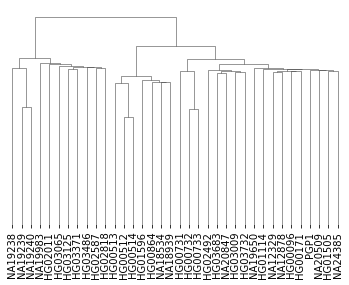

In [74]:
sb.matrix.dendrogram(snp, method="complete")

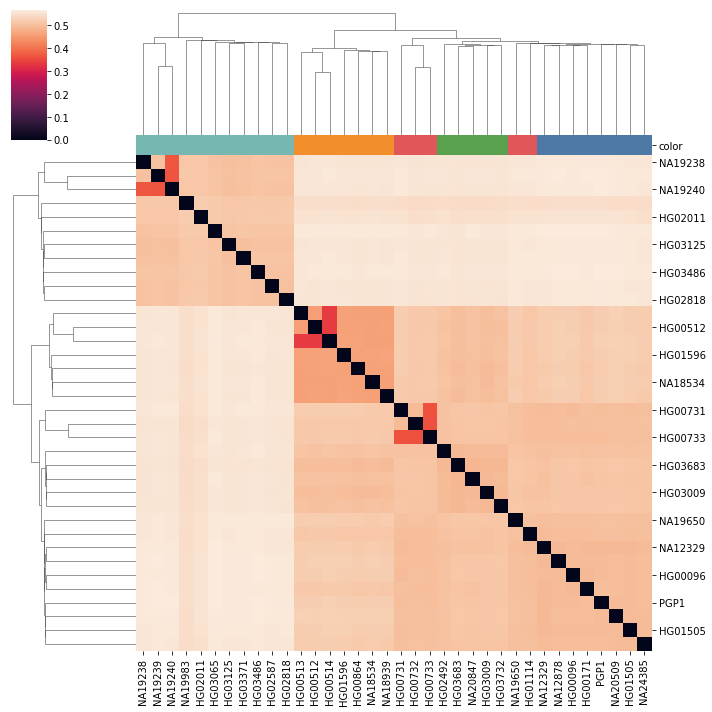

In [80]:
p = sb.clustermap(snp, method="complete", col_colors=metadata["color"])

/Users/a233287/pve/lib/python3.8/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


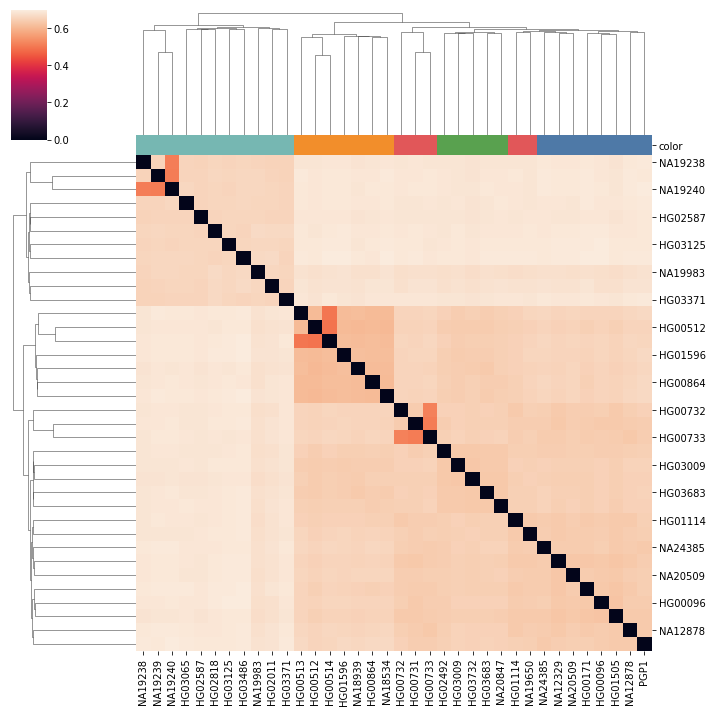

In [383]:
p = sb.clustermap(truv, method="complete", col_colors=metadata["color"])
#p.set(title="Truvari SV - SNP normalized Diff")

/Users/a233287/pve/lib/python3.8/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


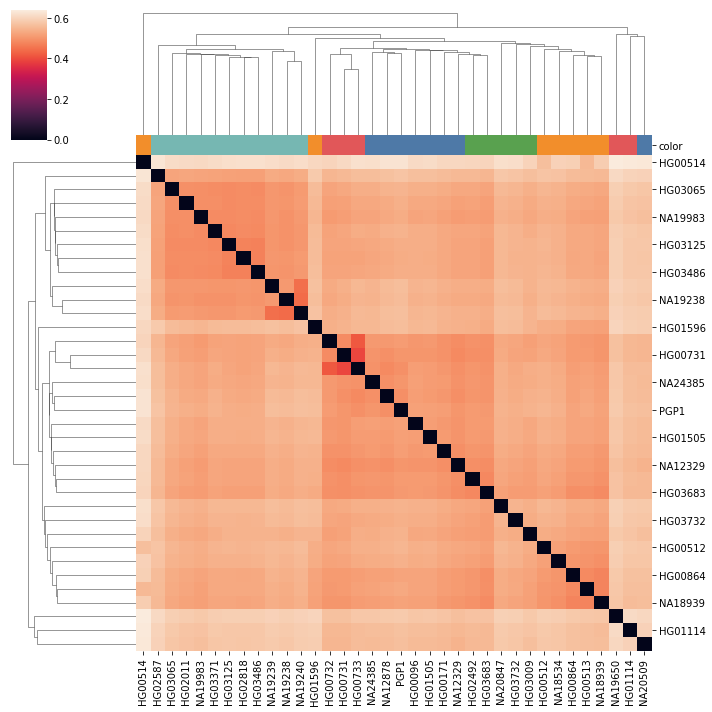

In [325]:
p = sb.clustermap(indels, method="complete", col_colors=metadata["color"])

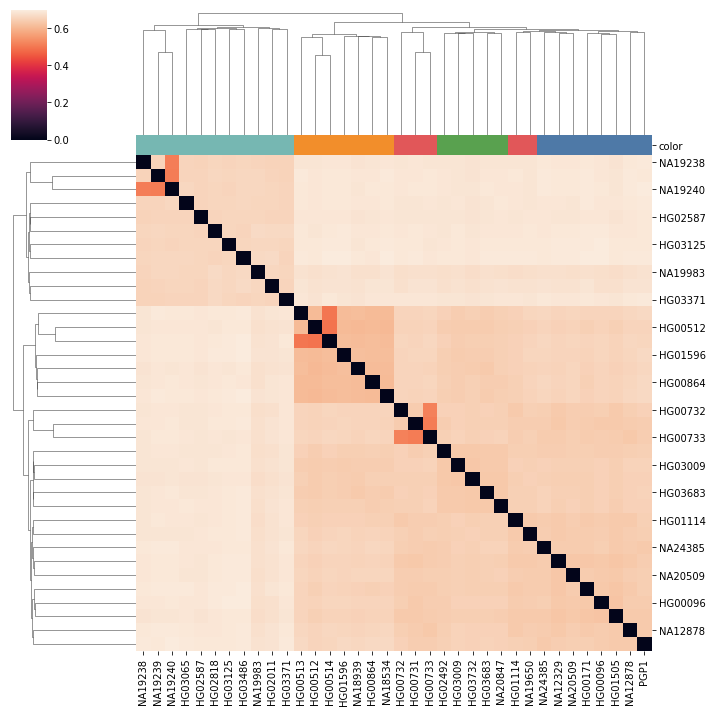

In [79]:
p = sb.clustermap(truv, method="complete", col_colors=metadata["color"])
#p.set(title="Truvari SV - SNP normalized Diff")

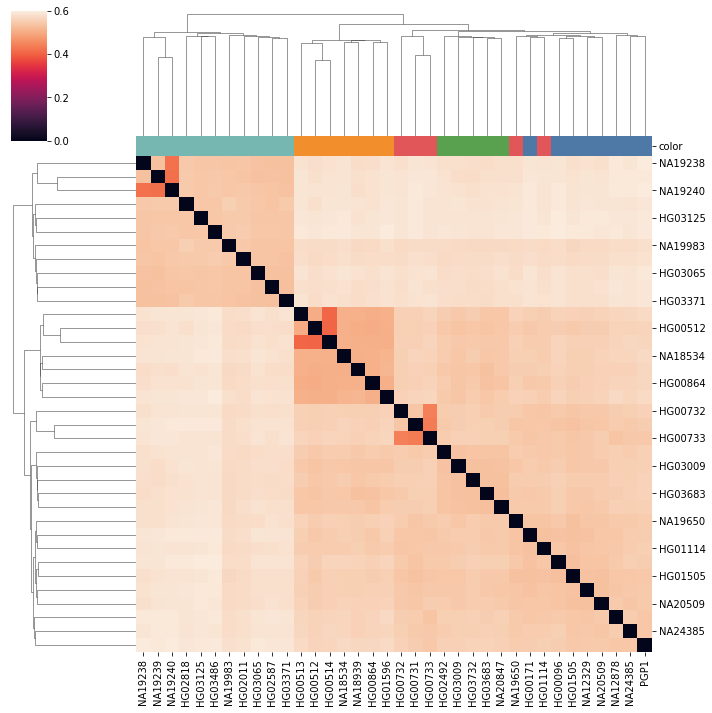

In [81]:
p = sb.clustermap(surv, method="complete", col_colors=metadata["color"])
#p.set(title="Survivor SV - SNP normalized Diff")

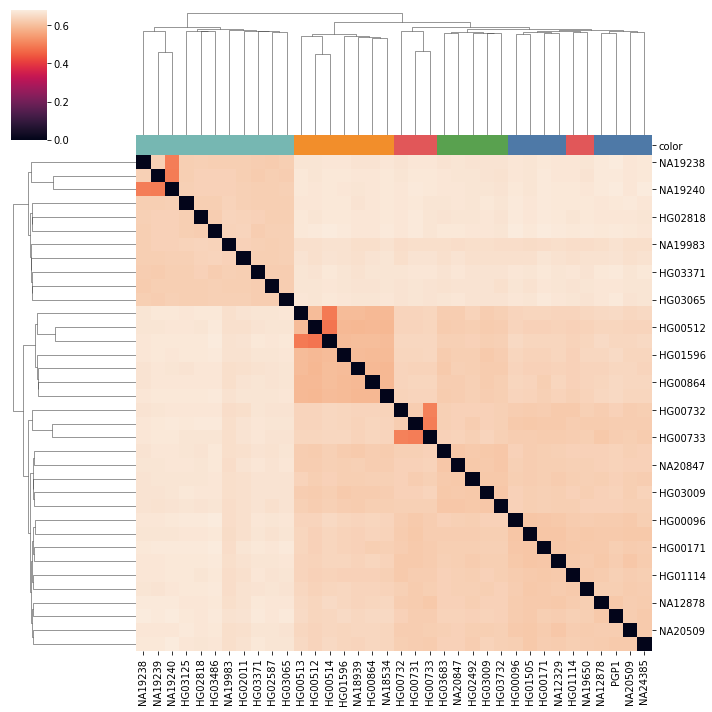

In [82]:
p = sb.clustermap(jas, method="complete", col_colors=metadata["color"])
#p.set(title="Jasmine SV - SNP normalized Diff")

In [8]:
rows = [[(truv_norm - snp_norm).mean(),
         (surv_norm - snp_norm).mean(), 
         (jas_norm - snp_norm).mean(),
         (nav_norm - snp_norm).mean(),
         (exa_norm - snp_norm).mean(),
         (ind_norm - snp_norm).mean()],
        [(truv_norm - snp_norm).std(), 
         (surv_norm - snp_norm).std(), 
         (jas_norm - snp_norm).std(),
         (nav_norm - snp_norm).std(),
         (exa_norm - snp_norm).std(),
         (ind_norm - snp_norm).std()]]
pd.DataFrame(rows, columns=["Truvari", "Survivor", "Jasmine", "Naive", "Exact", "INDEL"], index=["mean", "std"])

,Truvari,Survivor,Jasmine,Naive,Exact,INDEL
mean,0.000165,0.000124,0.000161,0.000137,0.000229,0.000079
std,0.003673,0.002888,0.003483,0.002918,0.005771,0.009157


In [9]:
def mkdist(a, b, title):
    x = normalize(a) - normalize(b)
    x = np.ravel(x[np.triu_indices(x.shape[0], 1)])
    x = x - x.mean()
    #sb.displot(np.ravel(x)).set(title=title)
    ret = pd.Series(x, name="NormDiff")
    ret = pd.DataFrame(ret)
    ret["Prog"] = title
    return ret

<AxesSubplot:xlabel='NormDiff', ylabel='Proportion'>

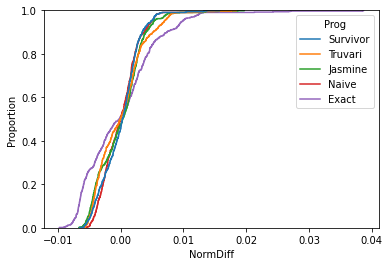

In [10]:
xmax = 0.08
rows = []
rows.append(mkdist(surv, snp, "Survivor"))
rows.append(mkdist(truv, snp, "Truvari"))
rows.append(mkdist(jas, snp, "Jasmine"))
rows.append(mkdist(nav, snp, "Naive"))
rows.append(mkdist(exa, snp, "Exact"))
#rows.append(mkdist(indels, snp, "Indel"))
d = pd.concat(rows).reset_index()
sb.ecdfplot(data=d, x="NormDiff", hue="Prog")

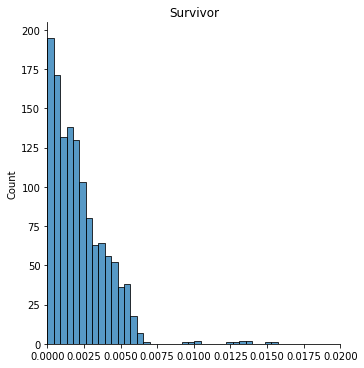

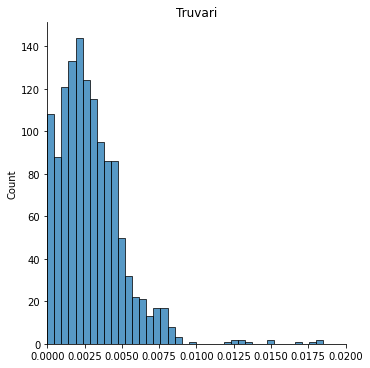

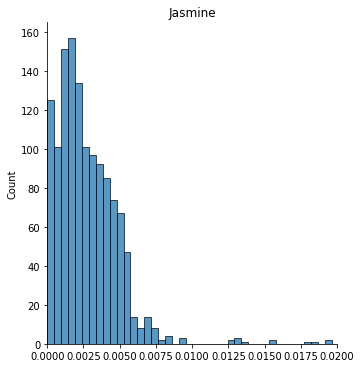

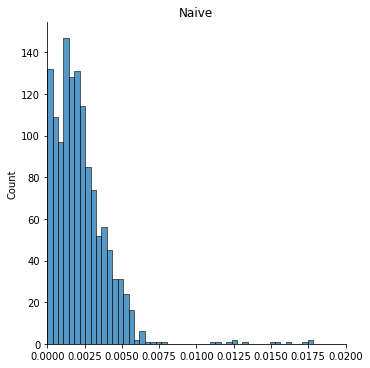

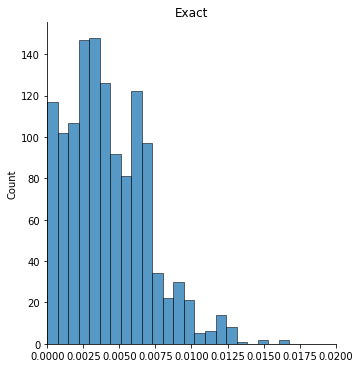

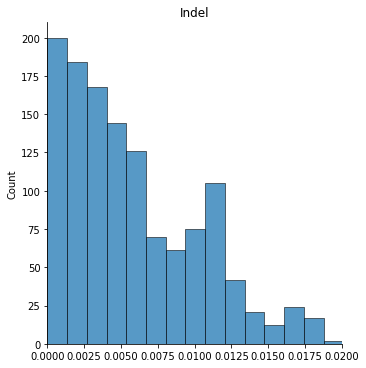

In [11]:
xmax = 0.02
p = sb.displot(np.ravel(np.abs(surv_norm - snp_norm)))
p.set(xlim=(0, xmax), title="Survivor")
plt.show()
p = sb.displot(np.ravel(np.abs(truv_norm - snp_norm)))
p.set(xlim=(0, xmax), title="Truvari")
plt.show()
p = sb.displot(np.ravel(np.abs(jas_norm - snp_norm)))
p.set(xlim=(0, xmax), title="Jasmine")
plt.show()
p = sb.displot(np.ravel(np.abs(nav_norm - snp_norm)))
p.set(xlim=(0, xmax), title="Naive")
plt.show()
p = sb.displot(np.ravel(np.abs(exa_norm - snp_norm)))
p.set(xlim=(0, xmax), title="Exact")
plt.show()
p = sb.displot(np.ravel(np.abs(ind_norm - snp_norm)))
p.set(xlim=(0, xmax), title="Indel")
plt.show()

In [340]:
truv.to_csv("truv.csv")
#np.savetxt("truv.csv", truv, delimiter=",")
snp.to_csv("snp.csv")
surv.to_csv("surv.csv")
jas.to_csv("jas.csv")
nav.to_csv("nav.csv") 
exa.to_csv("exa.csv")
indels.to_csv("ind.csv")

In [347]:
snp_pdm = dendropy.PhylogeneticDistanceMatrix.from_csv(
        src=open("snp.csv"),
        delimiter=",")
t_pdm = dendropy.PhylogeneticDistanceMatrix.from_csv(
        src=open("truv.csv"),
        delimiter=",")
s_pdm = dendropy.PhylogeneticDistanceMatrix.from_csv(
        src=open("surv.csv"),
        delimiter=",")
j_pdm = dendropy.PhylogeneticDistanceMatrix.from_csv(
        src=open("jas.csv"),
        delimiter=",")
n_pdm = dendropy.PhylogeneticDistanceMatrix.from_csv(
        src=open("nav.csv"),
        delimiter=",")
e_pdm = dendropy.PhylogeneticDistanceMatrix.from_csv(
        src=open("exa.csv"),
        delimiter=",")
i_pdm = dendropy.PhylogeneticDistanceMatrix.from_csv(
        src=open("ind.csv"),
        delimiter=",")
r_pdm = dendropy.PhylogeneticDistanceMatrix.from_csv(
        src=open("rnd.csv"),
        delimiter=",")

In [348]:
t_tree = t_pdm.nj_tree()
snp_tree = snp_pdm.nj_tree()
s_tree = s_pdm.nj_tree()
j_tree = j_pdm.nj_tree()
n_tree = n_pdm.nj_tree()
e_tree = e_pdm.nj_tree()
i_tree = i_pdm.nj_tree()
r_tree = r_pdm.nj_tree()

In [351]:
def calc_rfdist(snp, sv):
    tns = dendropy.TaxonNamespace()
    # ensure all trees loaded use common namespace
    tree1 = dendropy.Tree.get(
            data=snp.as_string("newick"),
            schema='newick',
            taxon_namespace=tns)
    tree2 = dendropy.Tree.get(
            data=sv.as_string("newick"),
            schema='newick',
            taxon_namespace=tns)
    #print(len([eg for eg in tree1.postorder_edge_iter()]))
    #print(len([eg for eg in tree2.postorder_edge_iter()]))
    ## Unweighted Robinson-Foulds distance
    return treecompare.symmetric_difference(tree1, tree2), \
           treecompare.false_positives_and_negatives(tree1, tree2), \
            treecompare.euclidean_distance(tree1, tree2), \
            

In [352]:
print("## Unweighted Robinson-Foulds distance: SNP to SV Merge")
print("Truvari:", calc_rfdist(snp_tree, t_tree))
print("Survivor:", calc_rfdist(snp_tree, s_tree))
print("Jasmine:", calc_rfdist(snp_tree, j_tree))
print("Naive:", calc_rfdist(snp_tree, n_tree))
print("Exact:", calc_rfdist(snp_tree, e_tree))
print("Indel:", calc_rfdist(snp_tree, i_tree))

## Unweighted Robinson-Foulds distance: SNP to SV Merge
Truvari: (40, (20, 20), 0.4417116757028979)
Survivor: (42, (21, 21), 0.16174855849716732)
Jasmine: (34, (17, 17), 0.38902619208152794)
Naive: (38, (19, 19), 0.27606476675865577)
Exact: (40, (20, 20), 0.7367533139977736)
Indel: (40, (20, 20), 0.23716290949340735)


In [17]:
trees = [snp_tree, i_tree, t_tree, s_tree, j_tree, n_tree, e_tree]
tlabels = ["SNP", "Indel", "Truvari", "Survivor", "Jasmine", "Naive", "Exact"]
rows = np.zeros((len(trees), len(trees)))
for i in range(len(trees)):
    for j in range(len(trees)):
        pars1 = len(trees[i].encode_bipartitions())
        pars2 = len(trees[j].encode_bipartitions())
        n_bi = max(pars1, pars2)
        rows[i][j] = 1 - (calc_rfdist(trees[i], trees[j])[1][0] / n_bi)

[Text(0.5, 1.0, 'NJ Tree Similarity')]

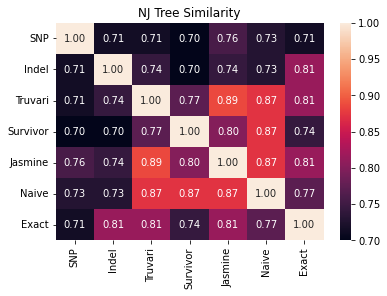

In [18]:
data = pd.DataFrame(rows, columns=tlabels, index=tlabels)
sb.heatmap(data, annot=True, fmt=".2f").set(title="NJ Tree Similarity")

In [19]:
data

,SNP,Indel,Truvari,Survivor,Jasmine,Naive,Exact
SNP,1.000000,0.714286,0.714286,0.700000,0.757143,0.728571,0.714286
Indel,0.714286,1.000000,0.742857,0.700000,0.742857,0.728571,0.814286
Truvari,0.714286,0.742857,1.000000,0.771429,0.885714,0.871429,0.814286
Survivor,0.700000,0.700000,0.771429,1.000000,0.800000,0.871429,0.742857
Jasmine,0.757143,0.742857,0.885714,0.800000,1.000000,0.871429,0.814286
Naive,0.728571,0.728571,0.871429,0.871429,0.871429,1.000000,0.771429
Exact,0.714286,0.814286,0.814286,0.742857,0.814286,0.771429,1.000000


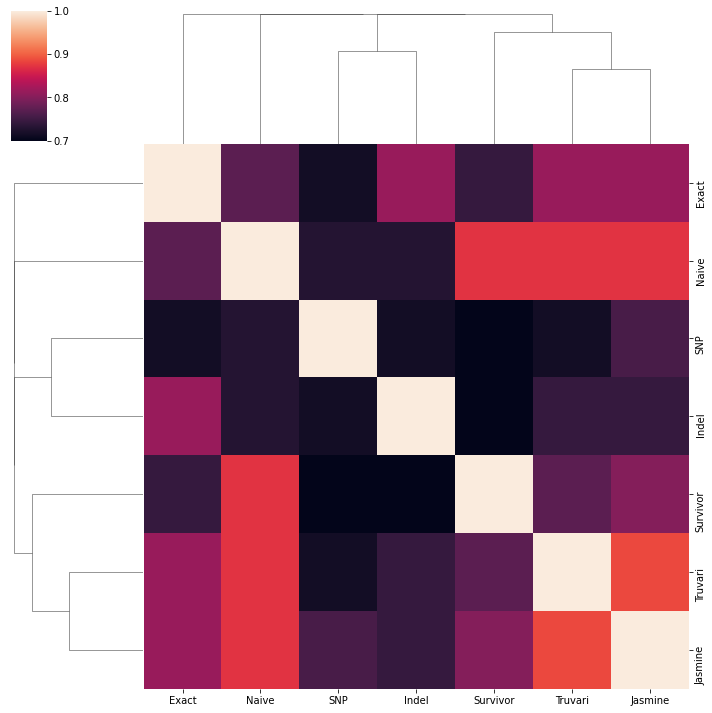

In [20]:
sb.clustermap(data, method="complete", metric="jaccard")

In [306]:
def mk_ecdf(fn):
    data = pd.read_csv(fn, sep="\t")
    are_same = data[["exact", "truvari", "jasmine", "survivor1k", "survivor5", "naive"]].max(axis=1) == data[["exact", "truvari", "jasmine", "survivor1k", "survivor5", "naive"]].min(axis=1)
    empty = data[["exact", "truvari", "jasmine", "survivor1k", "survivor5", "naive"]].max(axis=1) == 0
    diffs = data[~are_same & ~empty]
    for i in ["exact", "truvari", "jasmine", "survivor1k", "survivor5", "naive"]:
        diffs[i + '_pct'] = diffs[i] / diffs["exact"]
    progs = ["truvari", "jasmine", "survivor5", "naive"]
    parts = []
    for i in progs:
        parts.append(diffs[diffs["exact"] > 1].melt(value_vars=i + "_pct"))
    parts_ntr = pd.concat(parts)
    p = sb.ecdfplot(data=parts_ntr[parts_ntr["value"].between(0, 1)].reset_index(), 
                    x="value", 
                    hue="variable")
    sb.move_legend(p, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    p.set(title=f"ECDF of %SVs kept by merge per-1kb loci")
    plt.show()
    return diffs, data

/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_25066/628379246.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diffs[i + '_pct'] = diffs[i] / diffs["exact"]


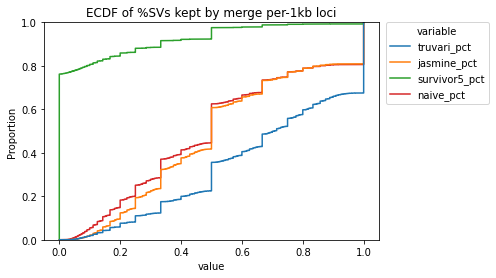

In [307]:
diffs, wind_cnt = mk_ecdf("all_sv_window_counts.bed")

[None]

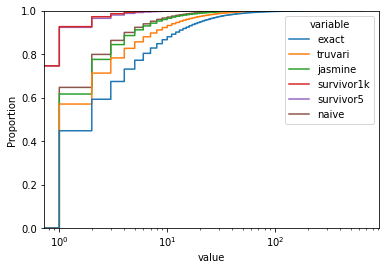

In [313]:
parts = []
s = wind_cnt[wind_cnt["exact"] != 0]
j = s.melt(value_vars=["exact", "truvari", "jasmine", "survivor1k", "survivor5", "naive"])
sb.ecdfplot(data=j, x="value", hue="variable").set(xscale="log")

[Text(0, 0.5, 'Proportion of 1kb Windows'),
 Text(0.5, 1.0, 'SV Count per-1kb Windows'),
 None,
 (0.8, 1.01)]

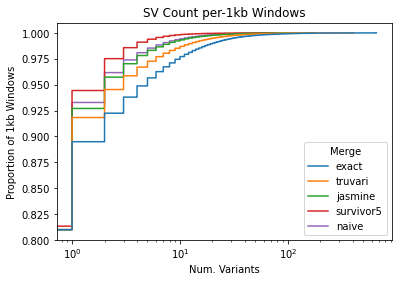

In [323]:
parts = []
s = wind_cnt#[wind_cnt["exact"] != 0]
j = s.melt(value_vars=["exact", "truvari", "jasmine", "survivor5", "naive"])
j.columns = ["Merge", "Num. Variants"]
p = sb.ecdfplot(data=j, hue="Merge", x="Num. Variants")
p.set(ylabel="Proportion of 1kb Windows", title="SV Count per-1kb Windows", xscale="log", ylim=(0.8,1.01))

[Text(0, 0.5, 'Proportion of 1kb Windows'),
 Text(0.5, 1.0, 'SV Count per-1kb Windows'),
 None]

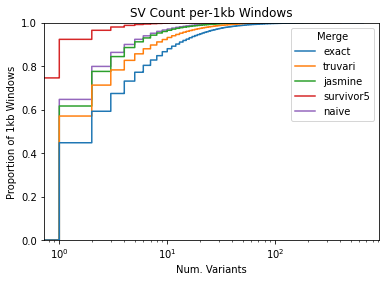

In [319]:
parts = []
s = wind_cnt[wind_cnt["exact"] != 0]
j = s.melt(value_vars=["exact", "truvari", "jasmine", "survivor5", "naive"])
j.columns = ["Merge", "Num. Variants"]
p = sb.ecdfplot(data=j, hue="Merge", x="Num. Variants")
p.set(ylabel="Proportion of 1kb Windows", title="SV Count per-1kb Windows", xscale="log")

In [23]:
pt_a = diffs_tr[diffs_tr["exact"] > 1][["chrom", "start", "end"]]
pt_b = diffs_ntr[diffs_ntr["exact"] > 1][["chrom", "start", "end"]]
pt = pd.concat([pt_a, pt_b])

In [24]:
pt.to_csv("new.bed", sep="\t", index=False, header=False)

1. Count SV starts for every 1kb region.
2. Annotate regions as TR or not (simple intersection)
3. Make the plots that show percents of SVs retained per 1kb site (describe more)
 1. For TR - This shows that SURVIVOR is collapsing everything (pretty much) naive/jasmine are in the middle, Truvari keeps them in tact
4. I then make trees out of the sites where they're different and whatever

In [89]:
t_tree.nodes()[0].taxon = "A"

In [93]:
t_tree.nodes()[0].

AttributeError: 'Node' object has no attribute 'awef'

In [126]:
import scipy.cluster.hierarchy as heir

#x = heir.linkage(snp, method="complete")
from collections import Counter
c = Counter()
names = [metadata.loc[_]["Superpopulation code"] for _ in snp.index] 
for i, j in zip(names, heir.fcluster(heir.linkage(snp, "complete"), 1)):
    c[str((i, j))] += 1
print(c)

Counter({"('EUR', 7)": 8, "('AFR', 2)": 8, "('SAS', 6)": 5, "('EAS', 4)": 4, "('EAS', 3)": 3, "('AMR', 5)": 3, "('AFR', 1)": 3, "('AMR', 7)": 2})


/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_25066/2215117497.py:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  for i, j in zip(names, heir.fcluster(heir.linkage(snp, "complete"), 1)):


In [140]:
import scipy.cluster.hierarchy as heir

#x = heir.linkage(snp, method="complete")
from collections import Counter
c = Counter()
names = [metadata.loc[_]["Superpopulation code"] for _ in truv.index] 
for i, j in zip(names, heir.fclusterdata(truv, 0.01)):
    c[str((i, j))] += 1
print(c)

Counter({"('EUR', 12)": 2, "('EAS', 1)": 2, "('AMR', 10)": 2, "('EAS', 3)": 2, "('AFR', 25)": 2, "('AFR', 23)": 2, "('SAS', 6)": 2, "('AFR', 21)": 2, "('EUR', 14)": 1, "('EAS', 2)": 1, "('AMR', 11)": 1, "('AMR', 18)": 1, "('EAS', 5)": 1, "('SAS', 7)": 1, "('AFR', 24)": 1, "('AFR', 27)": 1, "('AFR', 26)": 1, "('SAS', 8)": 1, "('EUR', 13)": 1, "('EUR', 16)": 1, "('EAS', 4)": 1, "('AFR', 22)": 1, "('AMR', 20)": 1, "('AFR', 28)": 1, "('EUR', 15)": 1, "('SAS', 9)": 1, "('EUR', 19)": 1, "('EUR', 17)": 1})


In [128]:
import scipy.cluster.hierarchy as heir

#x = heir.linkage(snp, method="complete")
from collections import Counter
c = Counter()
names = [metadata.loc[_]["Superpopulation code"] for _ in jas.index] 
for i, j in zip(names, heir.fcluster(heir.linkage(jas, "complete"), 1)):
    c[str((i, j))] += 1
print(c)

Counter({"('AFR', 3)": 5, "('SAS', 7)": 5, "('EUR', 8)": 4, "('EAS', 5)": 4, "('EAS', 4)": 3, "('AMR', 6)": 3, "('AFR', 2)": 3, "('AFR', 1)": 3, "('AMR', 9)": 2, "('EUR', 10)": 2, "('EUR', 11)": 2})


/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_25066/2864132561.py:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  for i, j in zip(names, heir.fcluster(heir.linkage(jas, "complete"), 1)):


In [134]:
heir.linkage(truv, "complete")

/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_25066/4031293050.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  heir.linkage(truv, "complete")


array([[ 2.        ,  4.        ,  0.70503904,  2.        ],
       [ 5.        ,  7.        ,  0.72679812,  2.        ],
       [28.        , 29.        ,  0.73122532,  2.        ],
       [ 3.        , 36.        ,  0.86068256,  3.        ],
       [ 8.        , 25.        ,  0.86245049,  2.        ],
       [26.        , 40.        ,  0.866194  ,  3.        ],
       [11.        , 41.        ,  0.8716856 ,  4.        ],
       [39.        , 42.        ,  0.88389314,  7.        ],
       [ 0.        , 10.        ,  0.88677609,  2.        ],
       [16.        , 22.        ,  0.8936986 ,  2.        ],
       [23.        , 32.        ,  0.89430382,  2.        ],
       [ 1.        , 44.        ,  0.89579054,  3.        ],
       [13.        , 45.        ,  0.89687536,  3.        ],
       [21.        , 33.        ,  0.89718493,  2.        ],
       [24.        , 35.        ,  0.89866166,  2.        ],
       [ 9.        , 30.        ,  0.90173531,  2.        ],
       [48.        , 49.

In [132]:
j = pd.DataFrame(heir.linkage(truv, "complete"))
j[4] = [metadata.loc[_]["Superpopulation code"] for _ in truv.index] 
j

/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_25066/529634729.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  j = pd.DataFrame(heir.linkage(truv, "complete"))


ValueError: Length of values (36) does not match length of index (35)

In [148]:
Z = heir.linkage(snp, "ward")
k=len(colors)
c = heir.fcluster(Z, k, criterion='maxclust')
cnt = Counter()
names = [metadata.loc[_]["Superpopulation code"] for _ in snp.index] 
for i, j in zip(names, c):
    cnt[str((i, j))] += 1
print(cnt)

Counter({"('EUR', 5)": 8, "('AFR', 2)": 8, "('EAS', 3)": 7, "('SAS', 5)": 5, "('AMR', 4)": 3, "('AFR', 1)": 3, "('AMR', 5)": 2})


/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_25066/1862887361.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = heir.linkage(snp, "ward")


In [149]:
Z = heir.linkage(truv, "ward")
k=len(colors)
c = heir.fcluster(Z, k, criterion='maxclust')
cnt = Counter()
names = [metadata.loc[_]["Superpopulation code"] for _ in truv.index] 
for i, j in zip(names, c):
    cnt[str((i, j))] += 1
print(cnt)

Counter({"('EUR', 5)": 8, "('AFR', 2)": 8, "('EAS', 3)": 7, "('SAS', 5)": 5, "('AMR', 4)": 3, "('AFR', 1)": 3, "('AMR', 5)": 2})


/var/folders/jv/tx_f68p54vv6wf2ylmpjnwkr0000gn/T/ipykernel_25066/4047348228.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = heir.linkage(truv, "ward")


In [248]:
from collections import defaultdict, Counter
from scipy.spatial.distance import squareform
import json
def clst(dat, t=1):
    Z = heir.linkage(squareform(dat.values), "complete")
    c = heir.fcluster(Z, t)
    cnt = defaultdict(Counter)
    pop = [metadata.loc[_]["Population code"] for _ in dat.index] 
    supop = [metadata.loc[_]["Superpopulation code"] for _ in dat.index] 
    for p, s, c in zip(pop, supop, c):
        cnt[int(c)][f"{p}"] += 1
    return cnt
    #print(json.dumps(dict(cnt), indent=4))

In [291]:
d = clst(snp, 0.0)
n_clusts = [_ for _ in d.keys()]
o_clusts = list(metadata["Population code"].unique())
x = np.zeros((len(n_clusts), len(o_clusts)))
for i in n_clusts:
    for j in o_clusts:
        ridx = n_clusts.index(i)
        cidx = o_clusts.index(j)
        x[ridx, cidx] += d[i][j]
x = pd.DataFrame(x, columns=o_clusts, index=n_clusts)
#sb.heatmap(x)
(x != 0).sum(axis=1).value_counts()

1    18
2     6
dtype: int64

In [289]:
d = clst(truv, 0.0)
n_clusts = [_ for _ in d.keys()]
o_clusts = list(metadata["Population code"].unique())
x = np.zeros((len(n_clusts), len(o_clusts)))
for i in n_clusts:
    for j in o_clusts:
        ridx = n_clusts.index(i)
        cidx = o_clusts.index(j)
        x[ridx, cidx] += d[i][j]
x = pd.DataFrame(x, columns=o_clusts, index=n_clusts)
#sb.heatmap(x)
(x != 0).sum(axis=1).value_counts()

1    15
2     8
dtype: int64

In [290]:
d = clst(jas, 0)
n_clusts = [_ for _ in d.keys()]
o_clusts = list(metadata["Population code"].unique())
x = np.zeros((len(n_clusts), len(o_clusts)))
for i in n_clusts:
    for j in o_clusts:
        ridx = n_clusts.index(i)
        cidx = o_clusts.index(j)
        x[ridx, cidx] += d[i][j]
x = pd.DataFrame(x, columns=o_clusts, index=n_clusts)
(x != 0).sum(axis=1).value_counts()

1    12
2    10
dtype: int64

In [292]:
d = clst(surv, 0.0)
n_clusts = [_ for _ in d.keys()]
o_clusts = list(metadata["Population code"].unique())
x = np.zeros((len(n_clusts), len(o_clusts)))
for i in n_clusts:
    for j in o_clusts:
        ridx = n_clusts.index(i)
        cidx = o_clusts.index(j)
        x[ridx, cidx] += d[i][j]
x = pd.DataFrame(x, columns=o_clusts, index=n_clusts)
(x != 0).sum(axis=1).value_counts()

1    17
2     8
dtype: int64

In [293]:
d = clst(nav, 0)
n_clusts = [_ for _ in d.keys()]
o_clusts = list(metadata["Population code"].unique())
x = np.zeros((len(n_clusts), len(o_clusts)))
for i in n_clusts:
    for j in o_clusts:
        ridx = n_clusts.index(i)
        cidx = o_clusts.index(j)
        x[ridx, cidx] += d[i][j]
x = pd.DataFrame(x, columns=o_clusts, index=n_clusts)
(x != 0).sum(axis=1).value_counts()

1    12
2    10
dtype: int64

In [354]:
from scipy.spatial import KDTree

In [355]:
j = KDTree(snp)

In [382]:
for f in [indels, truv, jas, surv, nav]:
    p = []
    print(j.query(f, .5)[0].mean())
    #p = pd.DataFrame(p, columns=["dist", "neigh"])
    #print(p["dist"].mean().mean())

0.2119525962497063
0.806145729329582
0.7036371473575114
0.2127213510696119
0.47238178667412406
